In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import numpy as np

# Q网络定义
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.fc(x)

# 经验回放池
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        return (
            torch.tensor(np.stack(states), dtype=torch.float32),
            torch.tensor(actions, dtype=torch.int64),
            torch.tensor(rewards, dtype=torch.float32),
            torch.tensor(np.stack(next_states), dtype=torch.float32),
            torch.tensor(dones, dtype=torch.float32),
        )

    def size(self):
        return len(self.buffer)


In [2]:
import matplotlib.pyplot as plt

def plot_dataList(rewards, xStart=0):
    # 设置图像的宽度为 12 英寸
    plt.figure(figsize=(12, 6))
    
    plt.plot(range(xStart, len(rewards) + xStart), rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Total Reward vs Episode')
    plt.show()


In [3]:
class DuelingDQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DuelingDQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
        )
        self.V = nn.Linear(128, 1)
        self.A = nn.Linear(128, output_dim)

    def forward(self, x):
        x = self.fc(x)
        V = self.V(x)
        A = self.A(x)
        Q = V + (A - A.mean(dim=1, keepdim=True))
        return Q

In [4]:
import numpy as np

class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6):
        """
        capacity: 缓冲区容量
        alpha: 优先级比例，0表示完全随机采样，1表示完全按优先级采样
        """
        self.capacity = capacity
        self.buffer = []
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.position = 0
        self.alpha = alpha

    def add(self, state, action, reward, next_state, done):
        """添加新经验，优先级初始化为最大值以确保被采样"""
        max_priority = self.priorities.max() if self.buffer else 1.0
        if len(self.buffer) < self.capacity:
            self.buffer.append((state, action, reward, next_state, done))
        else:
            self.buffer[self.position] = (state, action, reward, next_state, done)
        self.priorities[self.position] = max_priority
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size, beta=0.4):
        """
        采样带优先级的批次数据
        beta: 重要性采样的偏置修正参数
        """
        if len(self.buffer) == self.capacity:
            priorities = self.priorities
        else:
            priorities = self.priorities[:self.position]
        
        # 根据优先级分布计算采样概率
        probs = priorities ** self.alpha
        probs /= probs.sum()

        # 按照概率采样
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]

        # 计算重要性采样权重
        total = len(self.buffer)
        weights = (total * probs[indices]) ** (-beta)
        weights /= weights.max()

        # 解包样本
        states, actions, rewards, next_states, dones = zip(*samples)
        return (
            torch.tensor(np.stack(states), dtype=torch.float32),
            torch.tensor(actions, dtype=torch.int64),
            torch.tensor(rewards, dtype=torch.float32),
            torch.tensor(np.stack(next_states), dtype=torch.float32),
            torch.tensor(dones, dtype=torch.float32),
            torch.tensor(weights, dtype=torch.float32),
            indices,
        )

    def update_priorities(self, indices, priorities):
        """根据新的 TD Error 更新优先级"""
        self.priorities[indices] = priorities
    
    def size(self):
        return len(self.buffer)

In [5]:
import torch
import torch.nn as nn

class NoisyLinear(nn.Module):
    def __init__(self, in_features, out_features, std_init=0.5):
        super(NoisyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.std_init = std_init

        # 可训练参数
        self.weight_mu = nn.Parameter(torch.empty(out_features, in_features))
        self.weight_sigma = nn.Parameter(torch.empty(out_features, in_features))
        self.bias_mu = nn.Parameter(torch.empty(out_features))
        self.bias_sigma = nn.Parameter(torch.empty(out_features))

        # 非参数化噪声
        self.register_buffer("weight_epsilon", torch.empty(out_features, in_features))
        self.register_buffer("bias_epsilon", torch.empty(out_features))

        self.reset_parameters()
        self.reset_noise()

    def reset_parameters(self):
        # 初始化可训练参数
        bound = 1 / self.in_features ** 0.5
        self.weight_mu.data.uniform_(-bound, bound)
        self.weight_sigma.data.fill_(self.std_init / (self.in_features ** 0.5))
        self.bias_mu.data.uniform_(-bound, bound)
        self.bias_sigma.data.fill_(self.std_init / (self.in_features ** 0.5))

    def reset_noise(self):
        # 采样噪声
        self.weight_epsilon.normal_()
        self.bias_epsilon.normal_()

    def forward(self, x):
        if self.training:
            weight = self.weight_mu + self.weight_sigma * self.weight_epsilon
            bias = self.bias_mu + self.bias_sigma * self.bias_epsilon
        else:
            weight = self.weight_mu
            bias = self.bias_mu
        return torch.nn.functional.linear(x, weight, bias)

class Dueling_NoisyDQN(nn.Module):
    def __init__(self, input_shape, output_dim):
        super(Dueling_NoisyDQN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),  # (C, H, W) -> Conv,输出：32@20x20
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2), # 输出：64@9x9
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1), # 输出：64@7x7
            nn.ReLU(),
        )

        # 计算卷积后的特征图的尺寸
        conv_output_size = self._get_conv_output_size(input_shape)

        # Noisy 全连接层
        self.fc = nn.Sequential(
            NoisyLinear(conv_output_size, 512),
            nn.ReLU(),
        )

        # Dueling 分支
        self.V = NoisyLinear(512, 1)            # 状态价值分支
        self.A = NoisyLinear(512, output_dim)   # 优势值分支

    def _get_conv_output_size(self, shape):
        x = torch.zeros(1, *shape)  # 临时张量用于计算
        x = self.conv(x)
        return int(torch.flatten(x, 1).size(1))

    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, 1)  # 展平为向量
        x = self.fc(x)

        V = self.V(x)
        A = self.A(x)
        Q = V + (A - A.mean(dim=1, keepdim=True))
        return Q

    def reset_noise(self):
        for m in self.modules():
            if isinstance(m, NoisyLinear):
                m.reset_noise()

In [6]:
class MultiStepPrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6, n_step=3, gamma=0.99):
        """
        capacity: 缓冲区容量
        alpha: 优先级比例，0表示完全随机采样，1表示完全按优先级采样
        n_step: 多步时间跨度
        gamma: 折扣因子
        """
        self.capacity = capacity
        self.buffer = []
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.position = 0
        self.alpha = alpha
        self.n_step = n_step
        self.gamma = gamma

        # 用于多步存储的临时队列
        self.n_step_queue = []

    def _get_n_step_info(self):
        """从 n_step_queue 计算 n 步累计奖励和目标状态"""
        R = 0
        for idx, (_, _, reward, _, _) in enumerate(self.n_step_queue):
            R += (self.gamma ** idx) * reward
        state, action, _, next_state, done = self.n_step_queue[0]
        final_next_state, final_done = self.n_step_queue[-1][3], self.n_step_queue[-1][4]
        return (state, action, R, final_next_state, final_done)

    def add(self, state, action, reward, next_state, done):
        """
        添加新经验。
        使用 n_step_queue 缓存多步数据，只有在积累到 n 步时才存入 buffer。
        在轨迹结束时处理剩余的队列。
        """
        self.n_step_queue.append((state, action, reward, next_state, done))
        
        # 如果 n_step_queue 满了，处理一个完整的 n-step 转移
        if len(self.n_step_queue) == self.n_step:
            n_step_transition = self._get_n_step_info()
            max_priority = self.priorities.max() if self.buffer else 1.0
            if len(self.buffer) < self.capacity:
                self.buffer.append(n_step_transition)
            else:
                self.buffer[self.position] = n_step_transition
            self.priorities[self.position] = max_priority
            self.position = (self.position + 1) % self.capacity

            # 移除队列的第一个元素
            self.n_step_queue.pop(0)

        # 如果 done=True，处理剩余队列中的短步转移
        if done:
            while self.n_step_queue:
                n_step_transition = self._get_n_step_info()
                max_priority = self.priorities.max() if self.buffer else 1.0
                if len(self.buffer) < self.capacity:
                    self.buffer.append(n_step_transition)
                else:
                    self.buffer[self.position] = n_step_transition
                self.priorities[self.position] = max_priority
                self.position = (self.position + 1) % self.capacity

                # 移除队列的第一个元素
                self.n_step_queue.pop(0)

    def sample(self, batch_size, beta=0.4, device='cpu'):
        """
        采样带优先级的批次数据。
        """
        if len(self.buffer) == self.capacity:
            priorities = self.priorities
        else:
            priorities = self.priorities[:self.position]

        # 根据优先级分布计算采样概率
        probs = priorities ** self.alpha
        probs /= probs.sum()

        # 按照概率采样
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]

        # 计算重要性采样权重
        total = len(self.buffer)
        weights = (total * probs[indices]) ** (-beta)
        weights /= weights.max()

        # 解包样本
        states, actions, rewards, next_states, dones = zip(*samples)
        return (
            torch.tensor(np.stack(states), dtype=torch.float32).to(device),
            torch.tensor(actions, dtype=torch.int64).to(device),
            torch.tensor(rewards, dtype=torch.float32).to(device),
            torch.tensor(np.stack(next_states), dtype=torch.float32).to(device),
            torch.tensor(dones, dtype=torch.float32).to(device),
            torch.tensor(weights, dtype=torch.float32).to(device),
            indices,
        )

    def update_priorities(self, indices, priorities):
        """根据新的 TD Error 更新优先级"""
        self.priorities[indices] = priorities

    def size(self):
        return len(self.buffer)
    
    def current_queue_size(self):
        return len(self.n_step_queue)

In [7]:
import cv2

def preprocess_image(frame, method='binarize'):
    # 预处理图像：灰度化、裁剪、缩放、二值化
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame_cropped = frame_gray[:, :420]  # 裁剪掉地面部分
    frame_resize = cv2.resize(frame_cropped, (84, 84))
    if method == 'binarize':
        processed_frame = (frame_resize > 199).astype(np.uint8) #cv2.threshold(frame_resize, 199, 1, cv2.THRESH_BINARY)[1]
    else:
        # 归一化到 [0, 1]
        processed_frame = frame_resize / 255.0
    return processed_frame

In [ ]:
import os
import time
import pygame
import csv
from datetime import datetime
import configparser

fileName = 'models/fb_v0_no_score_2024-12-10_21-45-31.pth'
bestScoreFileName = 'flappy_bird_v0_model_best_score.pth'
stopTrainingFileName = 'flappy_bird_stop.txt'
guideFileName = 'result1/models/fb_v0_no_score_2024-12-07_16-37-46.pth'

def train_dueling_dqn_noise_MultiStep_PER(env, num_episodes=500, batch_size=64, gamma=0.99, 
                                          epsilon_schedule=[(0, 1.0), (20000, 0.1), (700000, 0.01), (1040000, 0.001), (1720000, 0.0001), (2060000, 0.0)], 
                                          lr=1e-3, alpha=0.6, beta_start=0.4, beta_increment=1e-4, 
                                          number_of_states=4, preprocessHeight=84, preprocessWidth=84, skip_frames=1):
    # 新的状态维度为原始状态维度的 number_of_states 倍
    input_shape = (number_of_states, preprocessHeight, preprocessWidth)
    output_dim = env.action_space.n

    # 检查是否有GPU可用
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    q_net = Dueling_NoisyDQN(input_shape, output_dim).to(device)
    # 判断是否存在fileName文件
    if os.path.exists(fileName):
        q_net.load_state_dict(torch.load(fileName, weights_only=True, map_location=device))
        print("模型已加载")
    q_net.train() # 设置为训练模式，需要通过训练更新参数，该行代码可以省略，因为默认就是训练模式
    target_net = Dueling_NoisyDQN(input_shape, output_dim).to(device)
    target_net.load_state_dict(q_net.state_dict())
    target_net.eval() # 设置为评估模式，不需要通过训练更新参数，更新时只需要复制q_net的参数

    optimizer = optim.Adam(q_net.parameters(), lr=lr)
    replay_buffer_capacity = 100000
    replay_buffer = MultiStepPrioritizedReplayBuffer(capacity=replay_buffer_capacity, alpha=alpha, n_step=20, gamma=gamma)
    epsilon = epsilon_schedule[0][1]
    beta = beta_start
    rewards = []  # 确保它是一个列表
    max_reward_total = -np.inf
    max_interval_rewards = -np.inf
    min_interval_rewards = np.inf
    max_score = 0
    max_step_count = 0
    update_step_count = 0
    update_step_interval = 200
    print_interval = 300  # 间隔（单位：秒）
    # 记录训练开始的时间
    last_save_time = time.time()
    last_print_time = last_save_time
    stop_training = False
    steps_Interval = 1000
    steps_perInterval = 0
    steps_total = 0
    loss_perInterval = 0
    q_value_perInterval = 0
    delta_training_frequency = 3
    delta_loss_threshold = 0.1
    # 获取当前时间戳
    current_time_str = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    csv_file = f'dueling_dqn_noise_MultiStep_PER_{current_time_str}.csv'
    aim_score = 10

    # 创建表格文件，列名分别为：总步数、epsilon、平均损失、平均Q值
    with open(csv_file, 'w') as f:
        f.write('Time,episode,Steps,epsilon,loss,Q_value\n')
        f.close()
    ratio_schedule = []
    for i in range(len(epsilon_schedule) - 1):
        start_step, start_epsilon = epsilon_schedule[i]
        end_step, end_epsilon = epsilon_schedule[i + 1]
        ratio = (end_epsilon - start_epsilon) / (end_step - start_step)
        ratio_schedule.append(ratio)
    
    print(f"Episode | min interval reward | max interval reward | max_reward_total | Epsilon | max_score | steps_total | lr | update_step_interval | training_frequency | loss_threshold | beta | replay_buffer.size")
    for episode in range(num_episodes):
        raw_state = env.reset()  # 返回 numpy.ndarray
        processed_frame = preprocess_image(raw_state)
        state_queue = deque([processed_frame.copy() for _ in range(number_of_states)], maxlen=number_of_states)  # 初始化队列，初始状态填充队列
        state = np.array(state_queue)
        total_reward = 0
        done = False
        step_count = 0
        reward_perSkip = 0
        score = 0

        while not done:  # 每个 episode 的最大步数
            # 根据多段线性衰减策略计算 epsilon
            for i in range(len(epsilon_schedule) - 1):
                start_step, start_epsilon = epsilon_schedule[i]
                end_step, end_epsilon = epsilon_schedule[i + 1]
                if start_step <= steps_total < end_step:
                    # 在当前阶段内进行线性插值
                    ratio = ratio_schedule[i]
                    epsilon = max(start_epsilon + ratio * (steps_total - start_step), end_epsilon)
            # 跳帧处理
            bSkip = True
            if step_count % skip_frames == 0:
                bSkip = False
                reward_perSkip = 0
                # ε-贪婪策略
                if random.random() < epsilon:
                    # 根据概率决定采样
                    if random.random() < 0.08 * skip_frames:
                        action = 1
                    else:
                        action = 0
                else:
                    with torch.no_grad():
                        action = q_net(torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)).argmax().item()
            else:
                action = 0

            # 执行动作
            next_raw_state, reward, done, info = env.step(action)
            step_count += 1
            steps_total += 1
            if max_step_count < step_count:
                max_step_count = step_count
            raw_state = next_raw_state
            if done:
                bSkip = False
            if bSkip == False:
                # 更新状态队列
                processed_frame = preprocess_image(raw_state)
                state_queue.append(processed_frame)
                next_state = np.array(state_queue)
            reward = reward * 0.1  # 缩放奖励
            # 得分
            bScore = False
            if info['score'] > score:
                reward += 0.4  # 奖励增加
                score = info['score']
                bScore = True
                if score % aim_score == 0:
                    bSkip = False
            if info['score'] > max_score:
                max_score = info['score']
                if max_score > 100:
                    torch.save(q_net.state_dict(), bestScoreFileName) # 保存模型
            if done:
                reward -= 0.2  # 惩罚
            reward_perSkip += reward
            if bSkip == False:
                if bScore:
                    if score % aim_score == 0:
                        replay_buffer.add(state, action, reward_perSkip, next_state, True) # 得到aim_score分结束，否则轨迹越长，Q值越大，无法收敛
                    else:
                        replay_buffer.add(state, action, reward_perSkip, next_state, done)
                else:
                    replay_buffer.add(state, action, reward_perSkip, next_state, done)
                state = next_state
            total_reward += reward
            if total_reward > max_reward_total:
                max_reward_total = total_reward
            if max_interval_rewards < total_reward:
                max_interval_rewards = total_reward

            # 经验回放训练
            if replay_buffer.size() >= batch_size and bSkip == False:
                training_frequency = 1
                loss_threshold = 0.5
                while training_frequency > 0:
                    # 从优先级缓冲区中采样
                    states, actions, rewards_batch, next_states, dones, weights, indices = replay_buffer.sample(batch_size, beta, device)

                    q_values = q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
                    with torch.no_grad():
                        q_value_perInterval += q_values.mean().item() / steps_Interval
                        best_actions = q_net(next_states).argmax(1)  # 使用当前网络选择最大Q值的动作
                        target_q_values = rewards_batch + gamma * (1 - dones) * target_net(next_states).gather(1, best_actions.unsqueeze(1)).squeeze(1)
                    # 计算 TD Error
                    td_errors = target_q_values - q_values
                    loss = (weights * td_errors.pow(2)).mean()
                    loss_perInterval += loss.item() / steps_Interval

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    # 更新优先级
                    priorities = td_errors.abs().detach().cpu().numpy()
                    replay_buffer.update_priorities(indices, priorities)
                    update_step_count += 1
                    steps_perInterval += 1
                
                    # 更新目标网络
                    if update_step_count >= update_step_interval:
                        update_step_count = 0
                        target_net.load_state_dict(q_net.state_dict()) # 将q_net的参数复制到target_net中
                    training_frequency -= 1
                    if loss.item() > loss_threshold and replay_buffer.size() >= replay_buffer_capacity * 0.5 and training_frequency == 0: # 如果损失大于阈值，且经验池已足够大，则重复训练，暂停与环境互动
                        training_frequency += delta_training_frequency
                        loss_threshold += delta_loss_threshold
                    if steps_perInterval >= steps_Interval:
                        # 追加数据到 CSV 文件
                        with open(csv_file, 'a') as f:
                            current_time_str = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                            f.write(f'{current_time_str},{episode},{steps_total},{epsilon},{loss_perInterval},{q_value_perInterval}\n')
                        steps_perInterval = 0
                        loss_perInterval = 0
                        q_value_perInterval = 0
                    # 检查时间间隔
                    current_time = time.time()
                    if current_time - last_save_time > 60:
                        # 读取配置文件
                        config = configparser.ConfigParser()
                        if config.read('config.ini'):
                            update_step_interval = config.getint('Training', 'update_step_interval')
                            delta_training_frequency_temp = config.getint('Training', 'delta_training_frequency')
                            if delta_training_frequency_temp >= 0:
                                delta_training_frequency = delta_training_frequency_temp
                            delta_loss_threshold_temp = config.getfloat('Training', 'delta_loss_threshold')
                            if delta_loss_threshold_temp > 0:
                                delta_loss_threshold = delta_loss_threshold_temp
                            lr_temp = config.getfloat('Training', 'lr')
                            if lr_temp > 0:
                                lr = lr_temp
                                state_dict = optimizer.state_dict()
                                state_dict['param_groups'][0]['lr'] = lr
                                optimizer.load_state_dict(state_dict)
                            beta_temp = config.getfloat('Training', 'beta')
                            if beta_temp > 0:
                                beta = beta_temp
                            stop_training = config.getboolean('Training', 'stop_training')
                            guideOpen = config.getboolean('Training', 'guideOpen')
                            
                        # 设置保存路径和合法文件名
                        save_path = "./models"
                        os.makedirs(save_path, exist_ok=True)  # 确保路径存在
                        current_time_str = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')  # 使用合法字符
                        currentNetFile = os.path.join(save_path, f'fb_rgb_v0_{current_time_str}.pth')
                        torch.save(q_net.state_dict(), currentNetFile) # 保存模型
                        last_save_time = current_time
                    if current_time - last_print_time >= print_interval:
                        last_print_time = current_time
                        print(f"{episode} | {min_interval_rewards:.3f} | {max_interval_rewards:.3f} | {max_reward_total:.3f} | {epsilon:.5f} | {max_score} | {steps_total} | {lr:.8e} | {update_step_interval} | {training_frequency} | {loss_threshold:.3f} | {beta:.5f} | {replay_buffer.size()}")
                        min_interval_rewards = np.inf
                        max_interval_rewards = -np.inf
                    # 更新 beta
                    beta = min(1.0, beta + beta_increment)

        rewards.append(total_reward)  # 确保 append 正常工作
        if min_interval_rewards > total_reward:
            min_interval_rewards = total_reward
        # 重置噪声
        q_net.reset_noise()
        target_net.reset_noise()
        if stop_training:
            # 把配置文件的stop_training改为False
            config['Training']['stop_training'] = 'False'
            with open('config.ini', 'w') as configfile:
                config.write(configfile)
            break

    return q_net, rewards

pygame 2.0.3 (SDL 2.0.16, Python 3.8.20)
Hello from the pygame community. https://www.pygame.org/contribute.html


配置文件已创建并写入初始内容。
Using device: cuda
Episode | min interval reward | max interval reward | max_reward_total | Epsilon | max_score | steps_total | lr | update_step_interval | training_frequency | loss_threshold | beta | replay_buffer.size
288 | 3.000 | 14.000 | 14.000 | 0.48243 | 1 | 28755 | 1.00000000e-05 | 100 | 0 | 0.500 | 1.00000 | 14531
546 | 9.900 | 15.000 | 15.000 | 0.08994 | 1 | 55589 | 1.00000000e-05 | 100 | 0 | 0.500 | 1.00000 | 28082
771 | 7.600 | 19.700 | 19.700 | 0.04636 | 3 | 79799 | 1.00000000e-05 | 100 | 0 | 0.500 | 1.00000 | 40328
986 | 9.900 | 16.300 | 19.700 | 0.01000 | 3 | 103544 | 1.00000000e-05 | 100 | 0 | 0.500 | 1.00000 | 52344
1183 | 9.900 | 18.100 | 19.700 | 0.01000 | 3 | 126565 | 1.00000000e-05 | 100 | 0 | 0.500 | 1.00000 | 63984
1372 | 9.900 | 18.100 | 19.700 | 0.01000 | 3 | 149684 | 1.00000000e-05 | 100 | 0 | 0.500 | 1.00000 | 75667
1545 | 9.900 | 19.700 | 19.700 | 0.00617 | 3 | 171283 | 1.00000000e-05 | 100 | 0 | 0.500 | 1.00000 | 86575
1721 | 9.900 | 18.600 

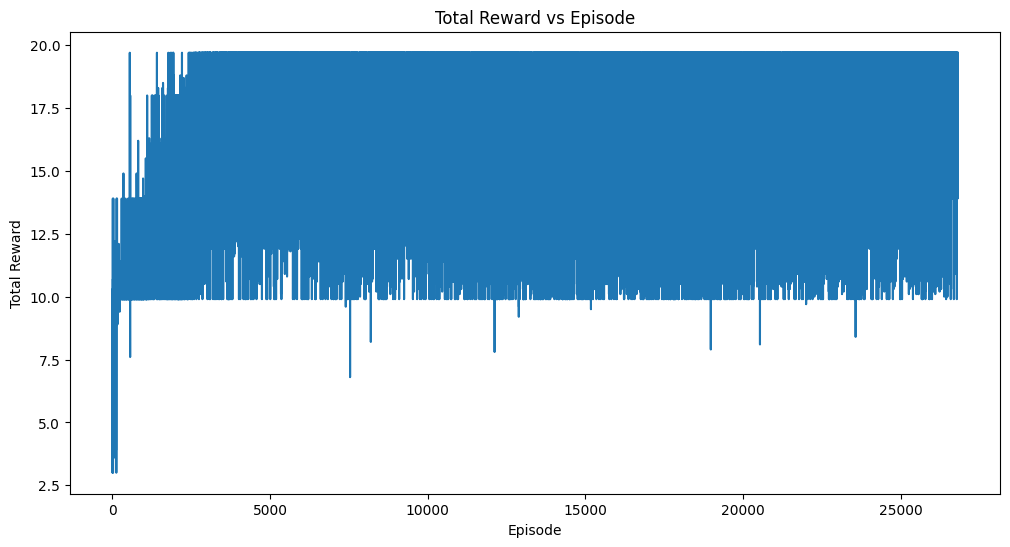

In [ ]:
import gym
import flappy_bird_gym
import configparser

# 创建ConfigParser对象
config = configparser.ConfigParser()

# 添加配置项
config['Training'] = {
    'update_step_interval': '100',
    'lr': '0.00001',
    'delta_training_frequency': '0',
    'delta_loss_threshold': '-0.1',
    'beta': '-0.1',
    'guideopen': 'False',
    'stop_training': 'False'
}

# 写入配置文件
with open('config.ini', 'w') as configfile:
    config.write(configfile)

print("配置文件已创建并写入初始内容。")

# 确保环境是 FlappyBird-v0
env = gym.make("FlappyBird-rgb-v0")
import os
import pygame

# 将声音输出重定向到"无声设备"
os.environ["SDL_AUDIODRIVER"] = "dummy"  # 设置虚拟音频驱动
pygame.mixer.quit()  # 重新初始化以应用设置

# 训练网络
q_net, rewards = train_dueling_dqn_noise_MultiStep_PER(
    env,
    num_episodes=50000,
    batch_size=64,
    gamma=0.99,
    epsilon_schedule=[(0, 1), (50000, 0.1), (100000, 0.01), (150000, 0.01), (200000, 0.001), (450000, 0.001), (500000, 0.0001), (650000, 0.0)],
    lr=1e-5,
    alpha=0.6,
    beta_start=0.4,
    beta_increment=1e-4,
    number_of_states=4,
    skip_frames=1
)
plot_dataList(rewards)
env.close()

In [10]:
import time
import flappy_bird_gym
import pygame

if os.path.exists(fileName):  # 判断是否存在fileName文件
    env = flappy_bird_gym.make("FlappyBird-v0")
    input_shape = env.observation_space.shape[0]
    output_dim = env.action_space.n
    q_net = Dueling_NoisyDQN(input_shape, output_dim)
    q_net.load_state_dict(torch.load(fileName, weights_only=True))
    q_net.eval()
    print("模型已加载")
    obs = env.reset()
    bExit = False
    current_score = 0
    min_steps_between_flaps = 999999
    steps_between_flaps = 0
    while bExit == False:
        obs = tuple(obs)
        # Next action:
        # (feed the observation to your agent here)
        action = q_net(torch.tensor(obs, dtype=torch.float32).unsqueeze(0)).argmax().item()

        # Processing:
        obs, reward, done, info = env.step(action)
        steps_between_flaps += 1
        if info['score'] > current_score:
            current_score = info['score']
            if steps_between_flaps < min_steps_between_flaps:
                min_steps_between_flaps = steps_between_flaps
            steps_between_flaps = 0
        # Rendering the game:
        # (remove this two lines during training)
        env.render()
        time.sleep(1 / 30)  # FPS

        # 处理 pygame 事件队列，防止窗口卡死
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                env.close()
                #exit()
                bExit = True
                done = True
        
        # Checking if the player is still alive
        if done:
            print(f"score: {info['score']}")
            print("Game Over")
            steps_between_flaps = 0
            obs = env.reset()

    env.close()
    print(f"min_steps_between_flaps: {min_steps_between_flaps}")